# CUSTOMER CHURN PREDICTION

Damini Vadrevu

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
customer = pd.read_csv("telecom_customer_churn.csv")

In [3]:
customer.head(10)
customer.shape

# Step 3: Check the distribution again to confirm the fix
print(customer['Customer Status'].value_counts())
# Exclude rows where 'Customer Status' is 'Joined'
customer = customer[customer['Customer Status'] != 'Joined']

# Proceed with binary classification


Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64


In [4]:
customer.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     644
Multiple Lines                        644
Internet Service                        0
Internet Type                        1344
Avg Monthly GB Download              1344
Online Security                      1344
Online Backup                        1344
Device Protection Plan               1344
Premium Tech Support                 1344
Streaming TV                         1344
Streaming Movies                  

## Missing Values

In [5]:
missingdata = customer.isnull().mean()
missingdata


Customer ID                          0.000000
Gender                               0.000000
Age                                  0.000000
Married                              0.000000
Number of Dependents                 0.000000
City                                 0.000000
Zip Code                             0.000000
Latitude                             0.000000
Longitude                            0.000000
Number of Referrals                  0.000000
Tenure in Months                     0.000000
Offer                                0.000000
Phone Service                        0.000000
Avg Monthly Long Distance Charges    0.097739
Multiple Lines                       0.097739
Internet Service                     0.000000
Internet Type                        0.203976
Avg Monthly GB Download              0.203976
Online Security                      0.203976
Online Backup                        0.203976
Device Protection Plan               0.203976
Premium Tech Support              

In [6]:

# Correlation matrix for missing values
missing_corr = customer.isnull().corr()


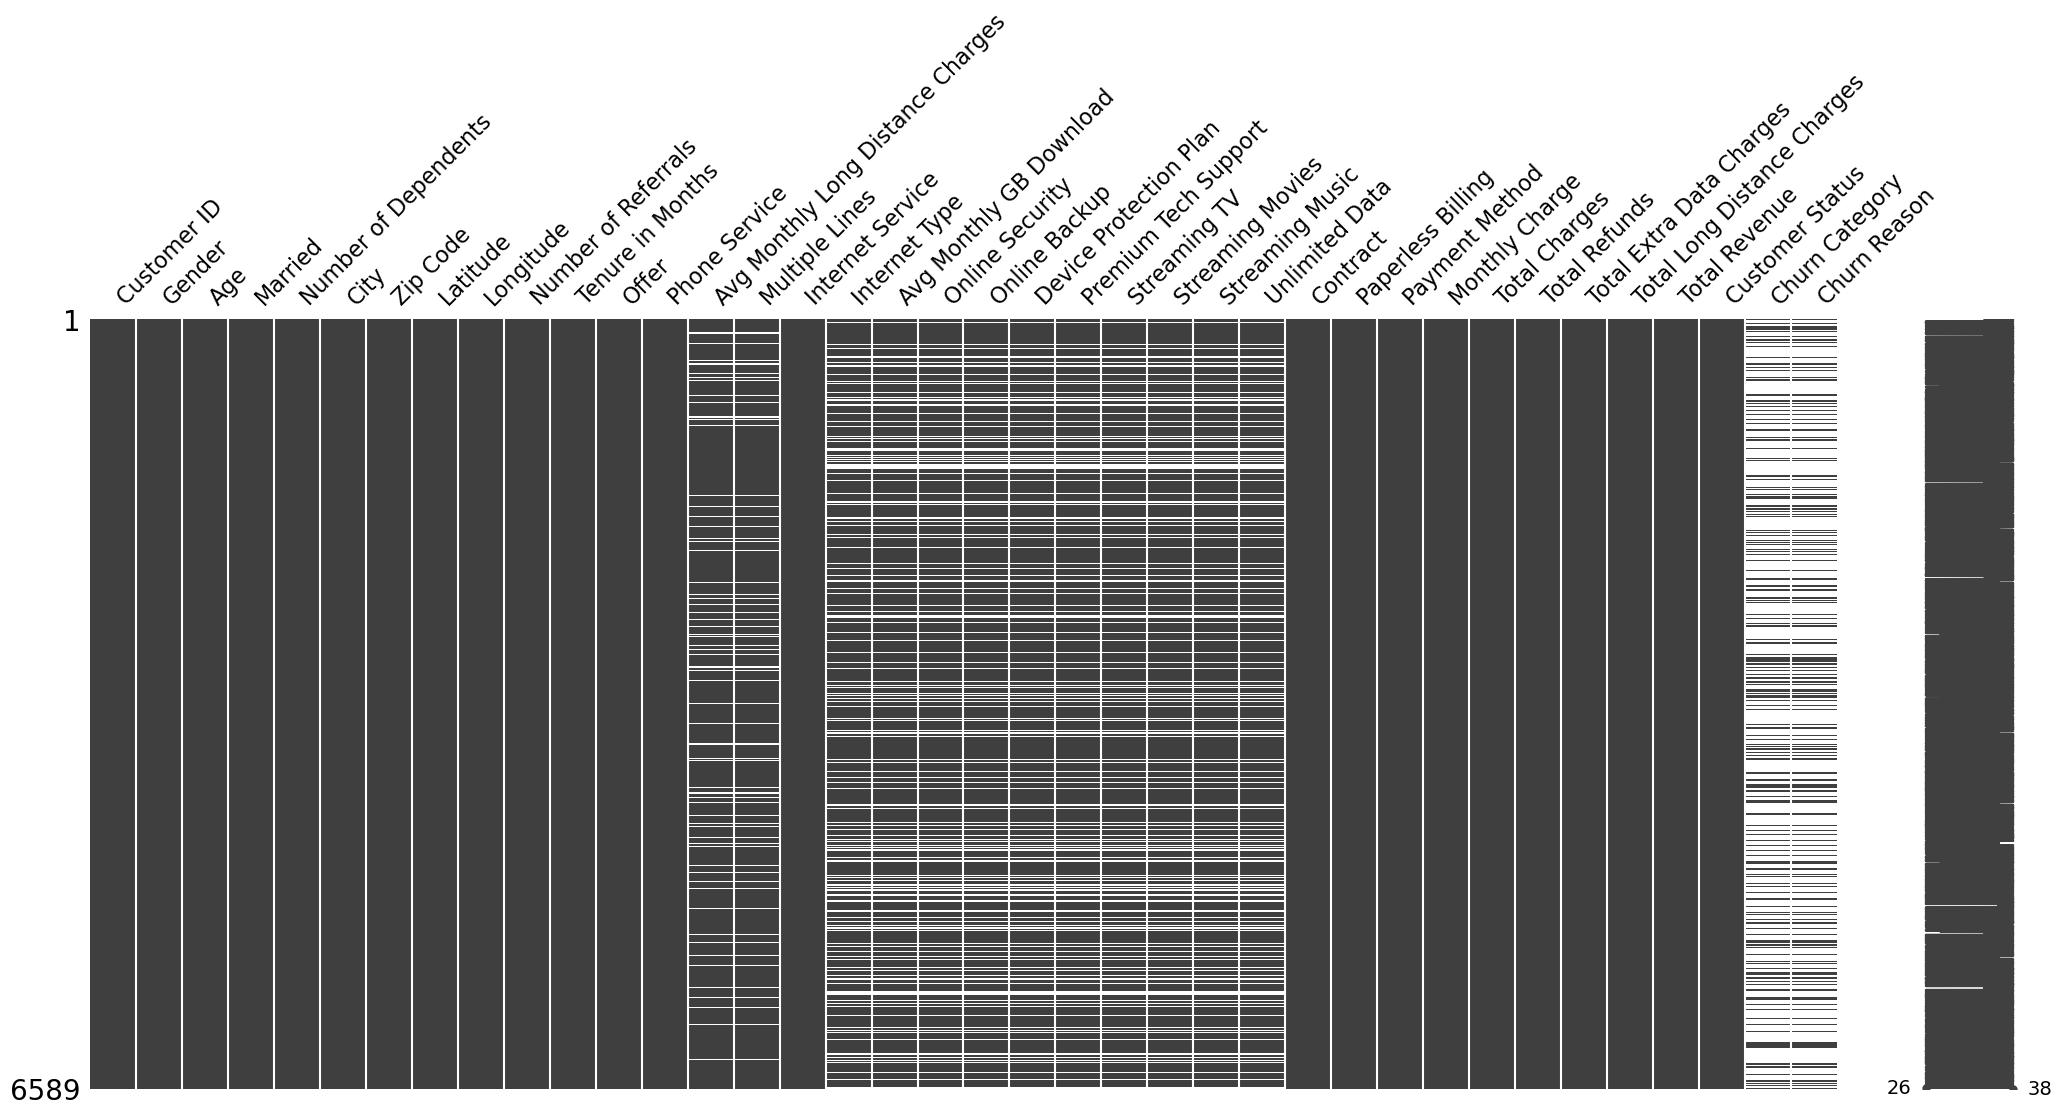

In [7]:
import missingno as msno
import pandas as pd

# Alternatively, create a matrix to visualize missing data patterns
msno.matrix(customer)
plt.show()


In [8]:
customer.groupby('Churn Category')['Internet Type'].apply(lambda x: x.isnull().sum())

Churn Category
Attitude           42
Competitor         22
Dissatisfaction     9
Other               3
Price              37
Name: Internet Type, dtype: int64

In [9]:
# Calculate total count and proportion of missing values
missing_info = customer.groupby('Churn Category')['Internet Type'].agg(['count', lambda x: x.isnull().sum(), lambda x: x.isnull().mean()])
missing_info.columns = ['Total Count', 'Missing Count', 'Missing Proportion']
print(missing_info)


                 Total Count  Missing Count  Missing Proportion
Churn Category                                                 
Attitude                 272             42            0.133758
Competitor               819             22            0.026159
Dissatisfaction          312              9            0.028037
Other                    179              3            0.016484
Price                    174             37            0.175355


The proportion of missing values is much higher for "Price" (17.54%) and "Attitude" (13.38%) compared to other categories like "Competitor" (2.62%) and "Dissatisfaction" (2.80%).
This pattern suggests that the missingness is not random but is dependent on the churn category, which indicates MNAR (Missing Not At Random). The missing values appear to be related to the reason for churn, meaning that the absence of data is systematically related to unobserved factors (likely related to specific churn reasons).

### Converting Missingness into a Feature - Handling MNAR

In [10]:
customer['Missing'] = customer['Churn Category'].isnull().astype(int)
customer.head(5)
#if missing -> 1 if not -> 0

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Missing
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,1
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,1
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,0
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,0
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,0


## PreProcessing - Converting all Variables into Numeric Form

In [11]:
# Map 'Customer Status' to numeric values
customer['Customer Status'] = customer['Customer Status'].map({'Churned': 1, 'Stayed': 0})

# Now perform target encoding
target_mean = customer.groupby('Churn Category')['Customer Status'].mean()

# Map the target mean values to 'Churn Category'
customer['Churn Category'] = customer['Churn Category'].map(target_mean)

In [12]:
# Convert 'Gender' to binary (0 for Female, 1 for Male)
customer['Gender'] = customer['Gender'].map({'Female': 0, 'Male': 1})

# Convert 'Married' to binary (1 for Yes, 0 for No)
customer['Married'] = customer['Married'].map({'Yes': 1, 'No': 0})

# Check the updated DataFrame
print(customer[['Gender', 'Married']].head())


   Gender  Married
0       0        1
1       1        0
2       1        0
3       1        1
4       0        1


In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Label encode 'City'
customer['City'] = label_encoder.fit_transform(customer['City'])

# Label encode 'Customer ID'
customer['Customer ID'] = label_encoder.fit_transform(customer['Customer ID'])

# Check the updated DataFrame
print(customer[['Customer ID', 'City']].head())


   Customer ID  City
0            0   346
1            1   368
2            2   222
3            3   587
4            4   139


In [14]:
# Now perform target encoding
target_mean = customer.groupby('Churn Reason')['Customer Status'].mean()

# Map the target mean values to 'Churn Category'
customer['Churn Reason'] = customer['Churn Reason'].map(target_mean)


In [15]:
# List of columns to convert to binary variables
binary_columns = [
    'Internet Service', 'Online Security', 'Online Backup', 
    'Device Protection Plan', 'Premium Tech Support', 
    'Streaming TV', 'Streaming Movies', 'Streaming Music', 
    'Unlimited Data', 'Paperless Billing', 'Phone Service', 
    'Multiple Lines'
]

# Replace 'Yes' with 1 and 'No' with 0 in these columns
customer[binary_columns] = customer[binary_columns].replace({'Yes': 1, 'No': 0})


In [16]:
label_encoder = LabelEncoder()

# Apply label encoding to the 'Offer' column
customer['Offer'] = label_encoder.fit_transform(customer['Offer'])


In [17]:
# Perform one-hot encoding for the 'Internet Type' column
customer = pd.get_dummies(customer, columns=['Internet Type'], drop_first=True)

# Perform one-hot encoding for the 'Contract' column
customer = pd.get_dummies(customer, columns=['Contract'], drop_first=True)

# Perform one-hot encoding for the 'Payment Method' column
customer = pd.get_dummies(customer, columns=['Payment Method'], drop_first=True)

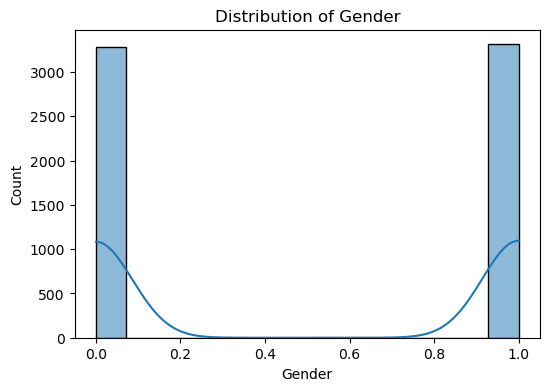

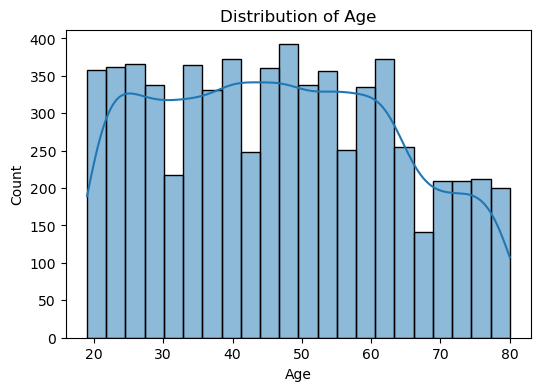

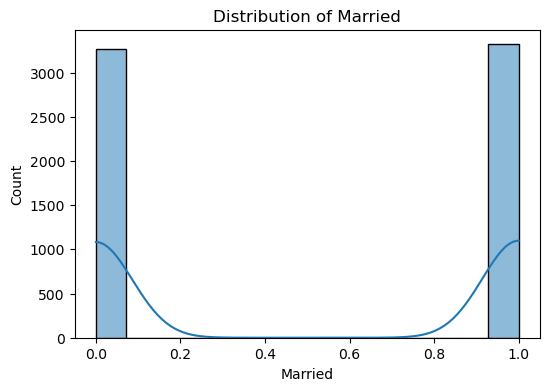

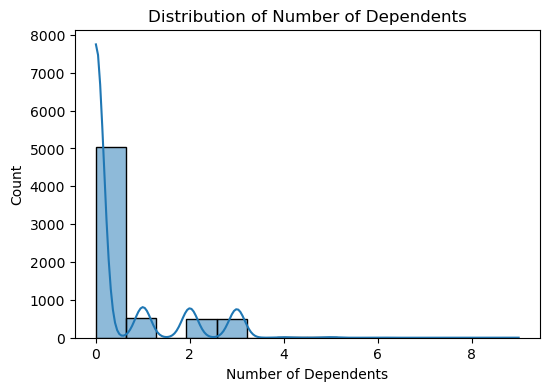

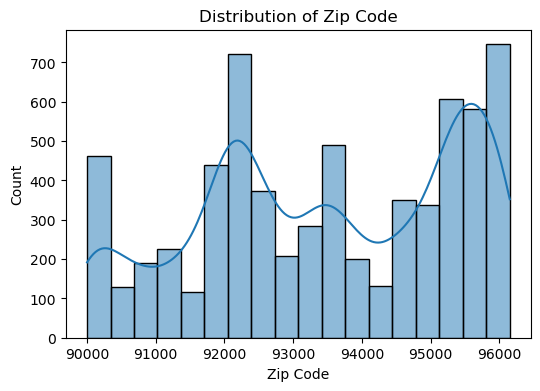

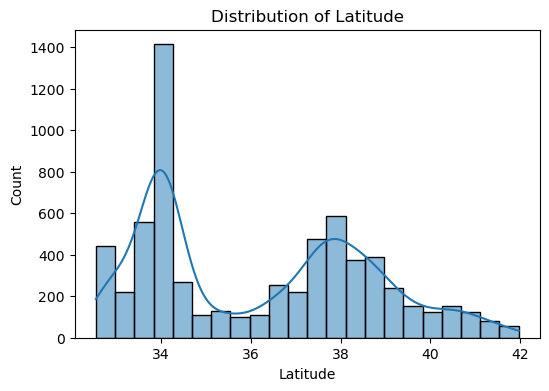

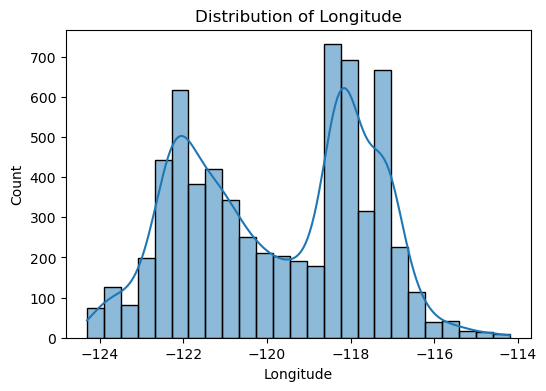

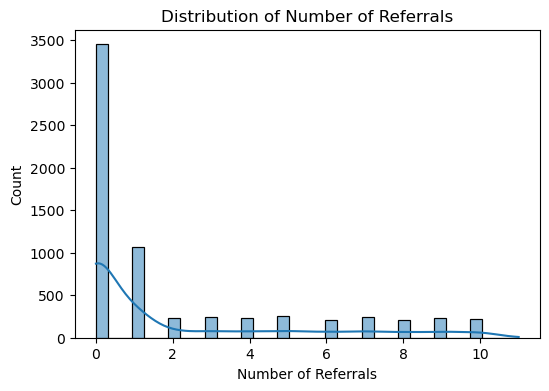

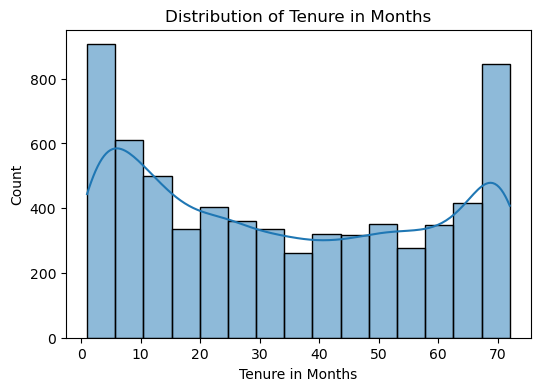

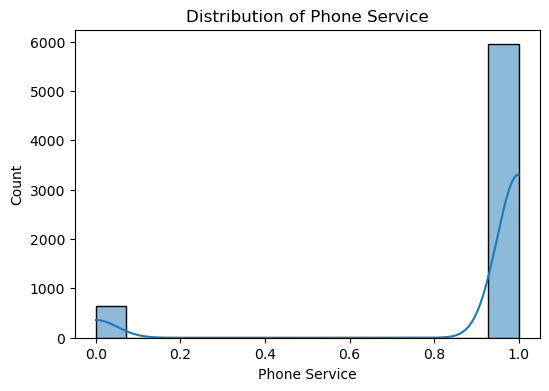

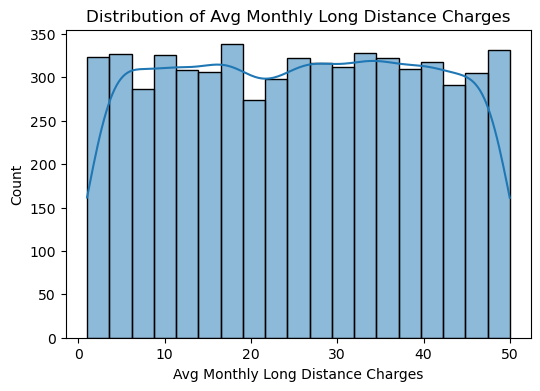

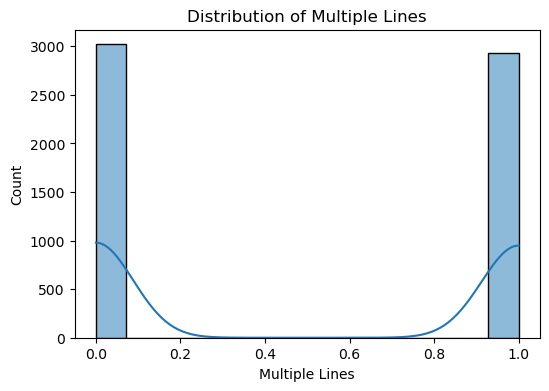

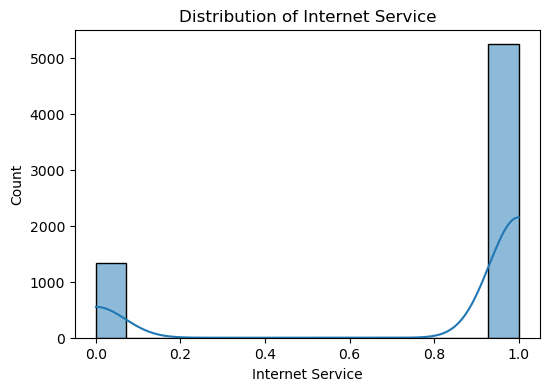

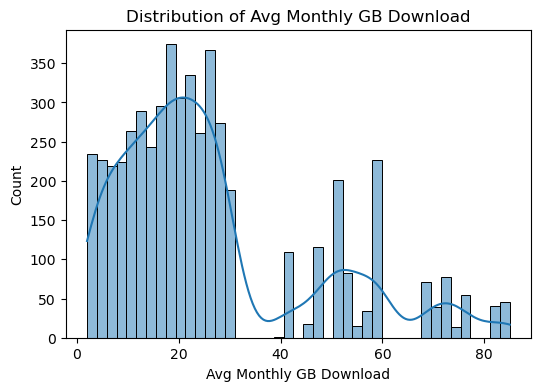

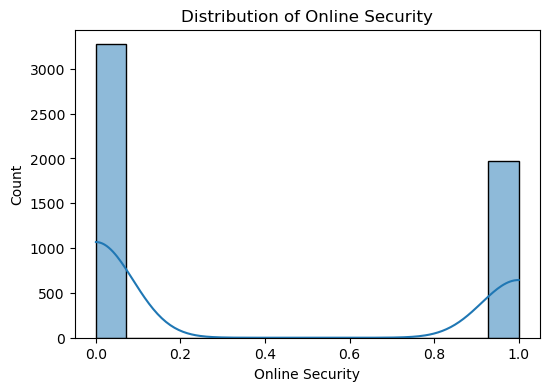

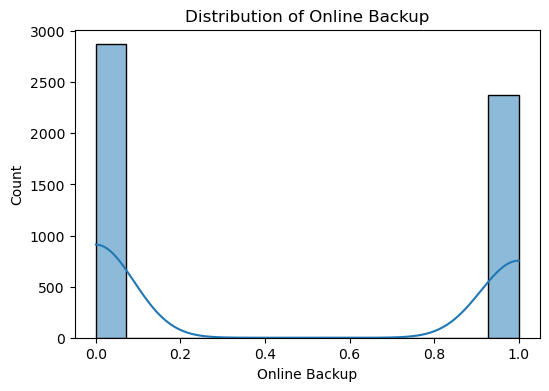

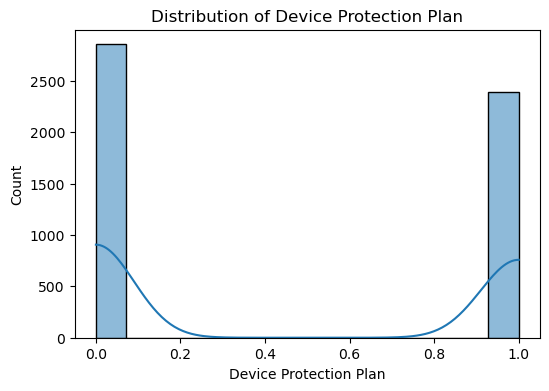

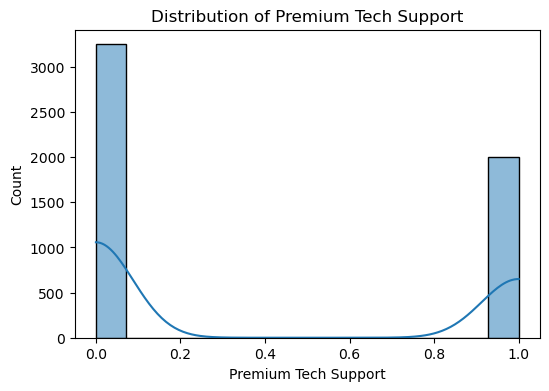

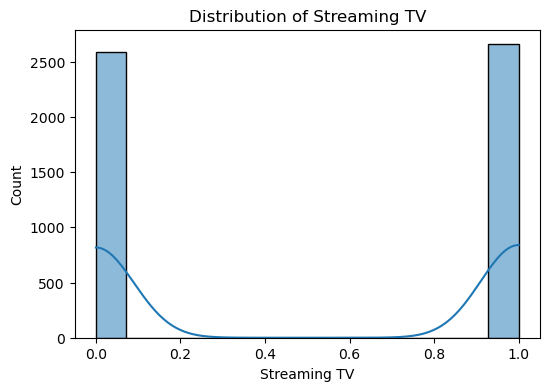

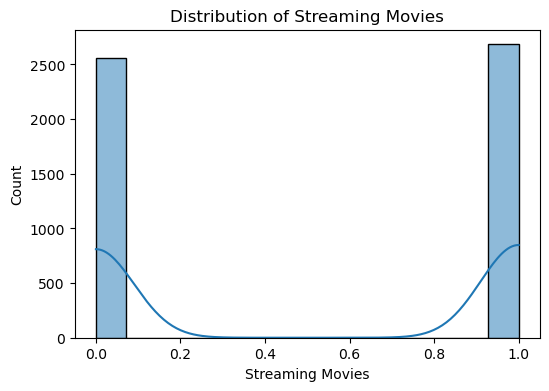

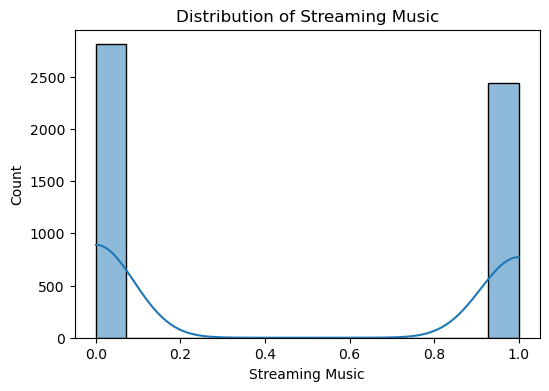

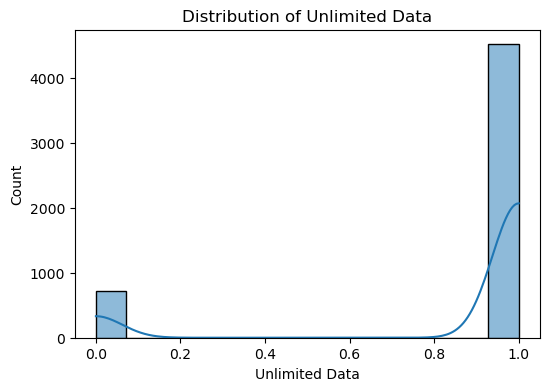

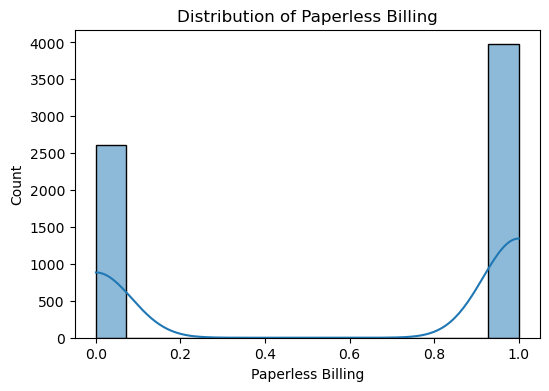

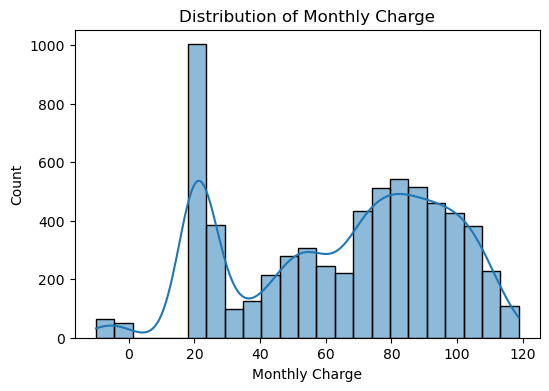

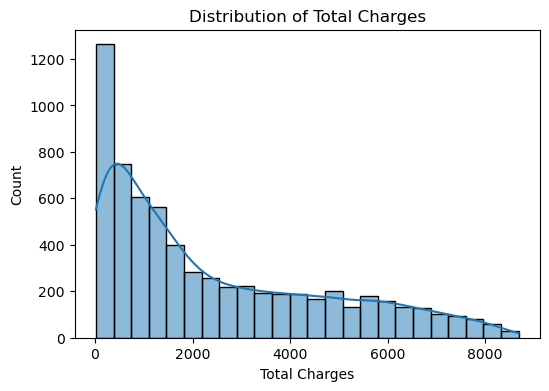

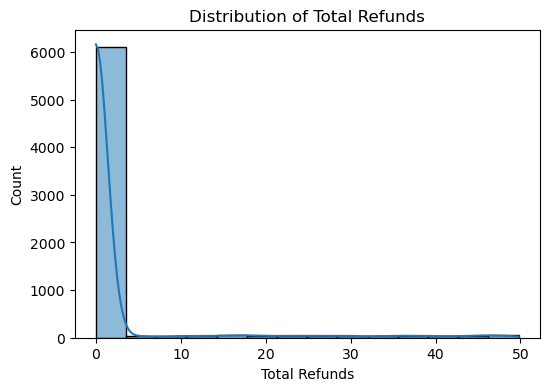

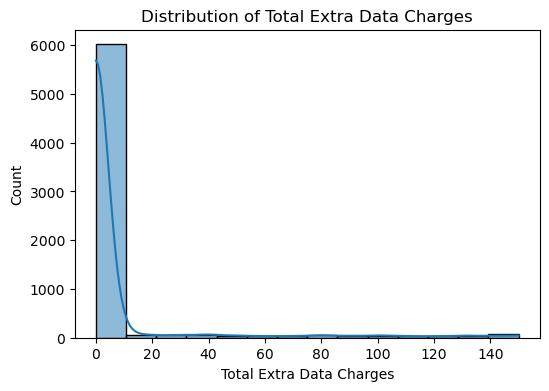

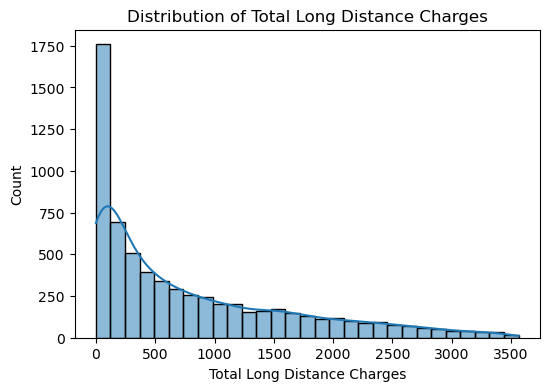

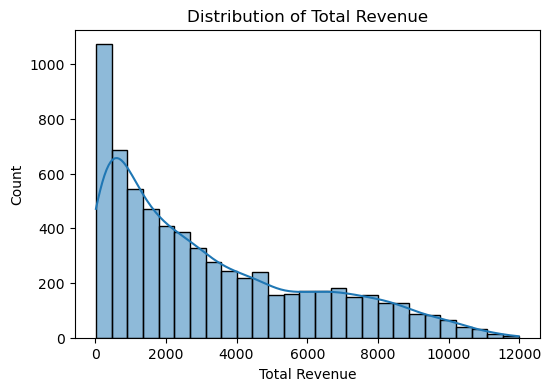

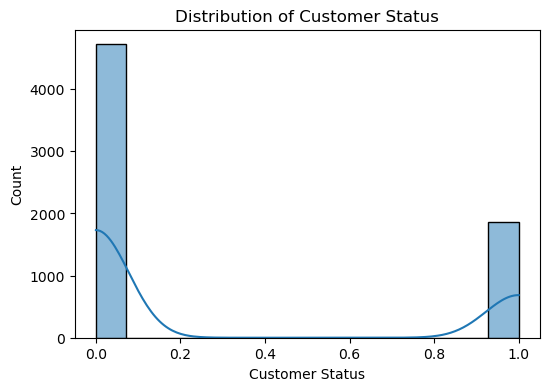

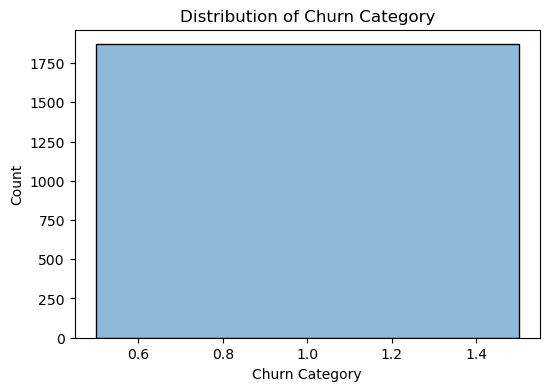

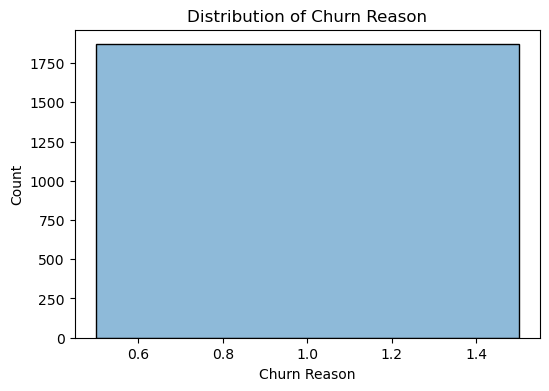

In [18]:


# Assuming 'customer' is your dataset (replace with your actual dataset name)
data = customer

# Loop through all the columns in the dataset
for column in data.columns:
    # Check if the column is numeric
    if data[column].dtype in ['int64', 'float64']:  # Only plot numeric columns
        plt.figure(figsize=(6, 4))  # Set the figure size for each plot
        sns.histplot(data[column], kde=True)  # Plot histogram with KDE
        plt.title(f'Distribution of {column}')  # Set plot title
        plt.xlabel(column)  # Set x-axis label
        plt.ylabel('Count')  # Set y-axis label
        plt.show()  # Display the plot


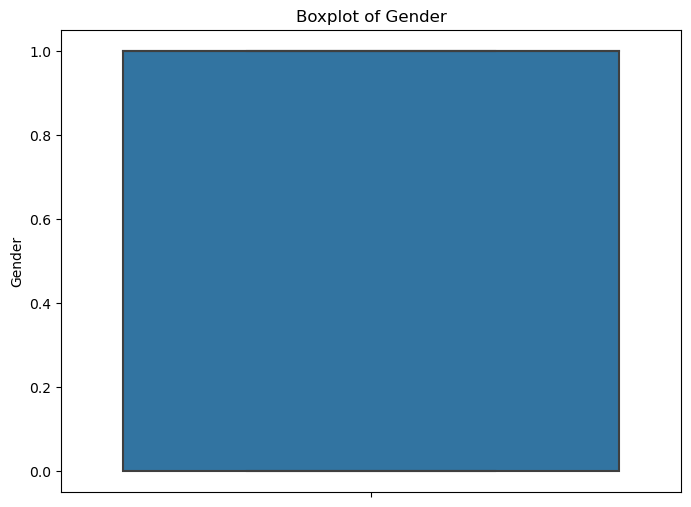

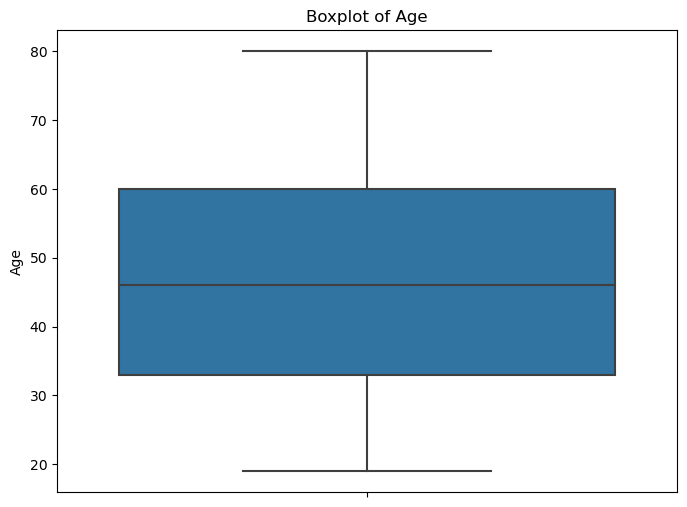

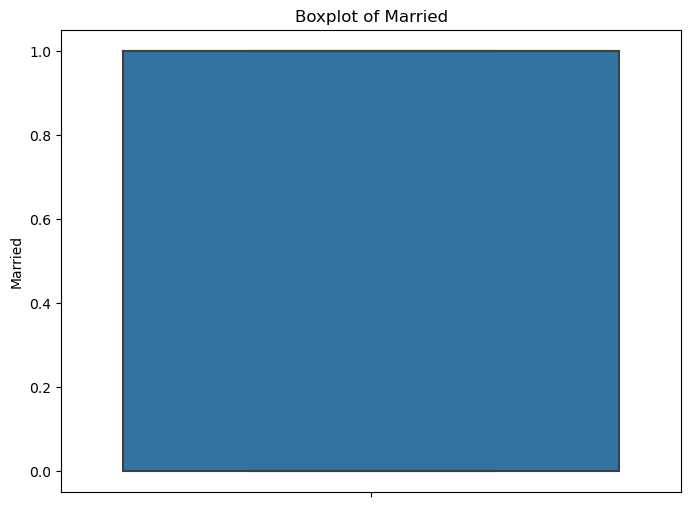

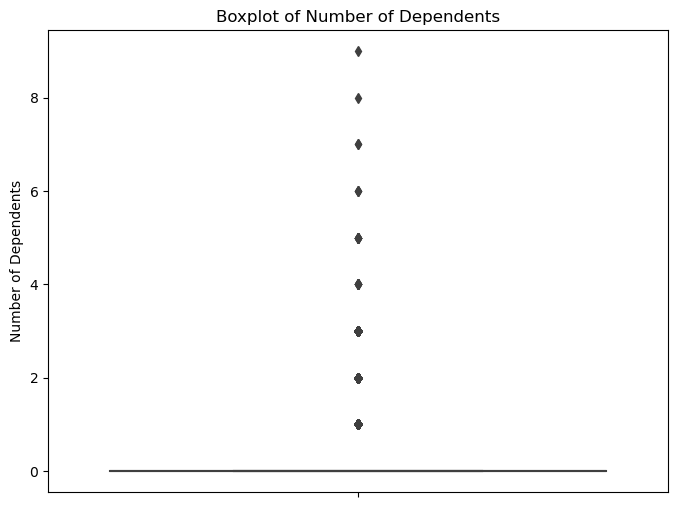

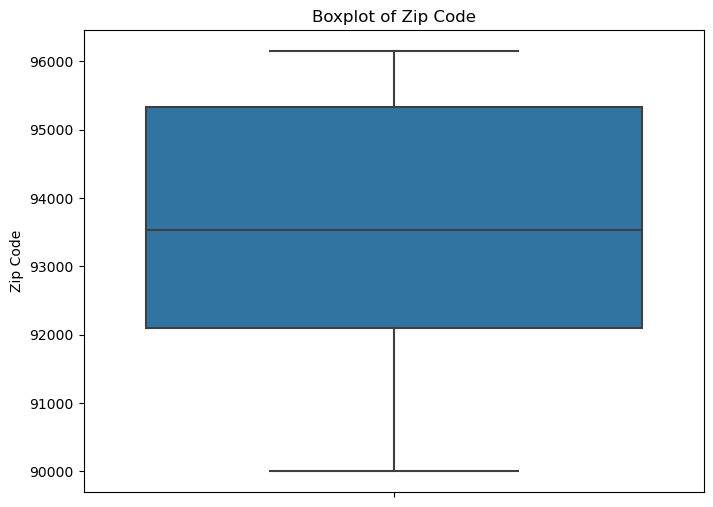

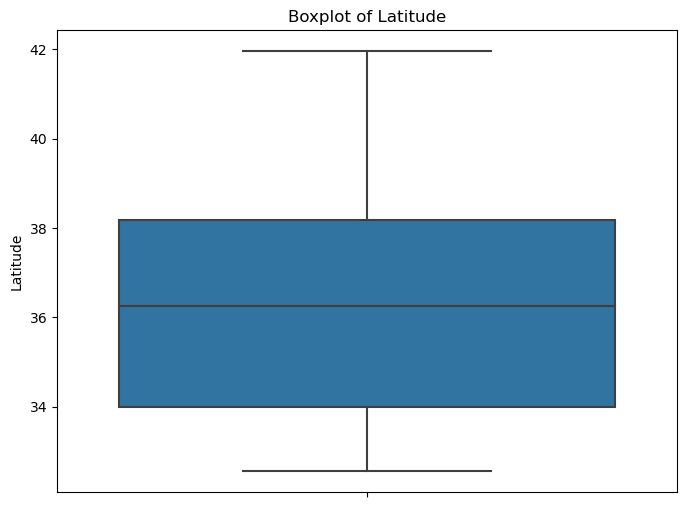

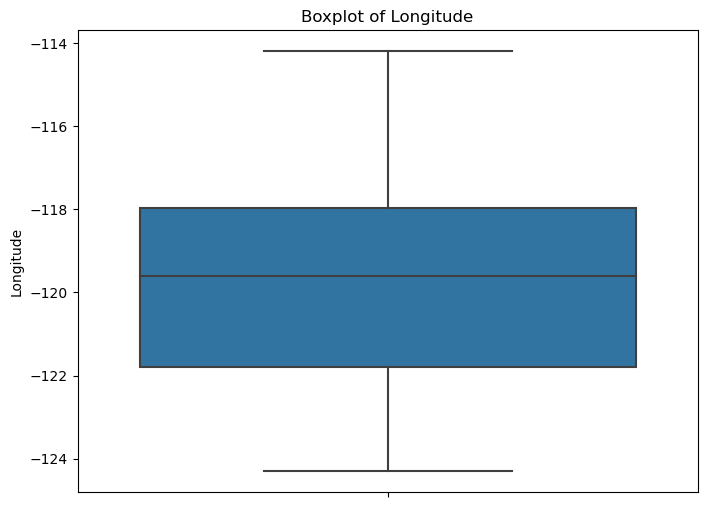

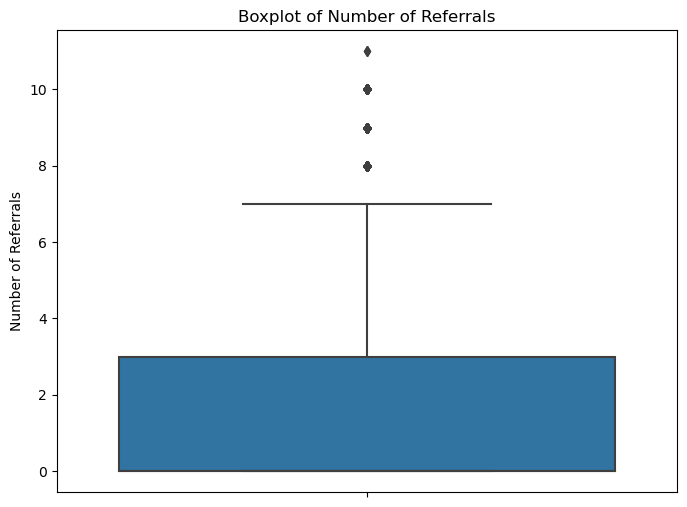

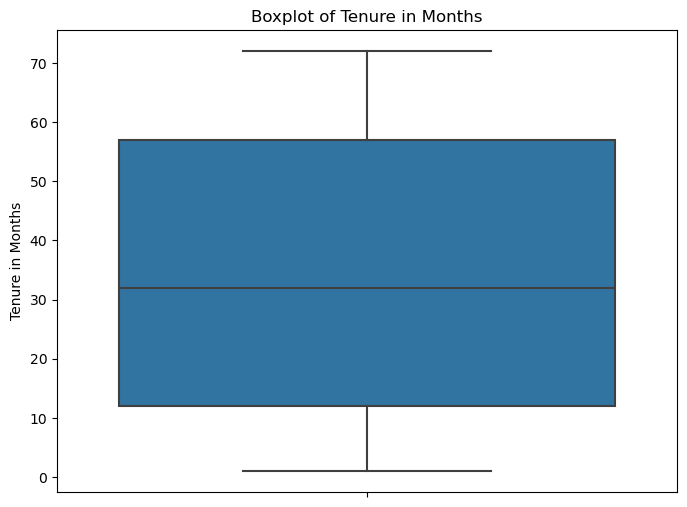

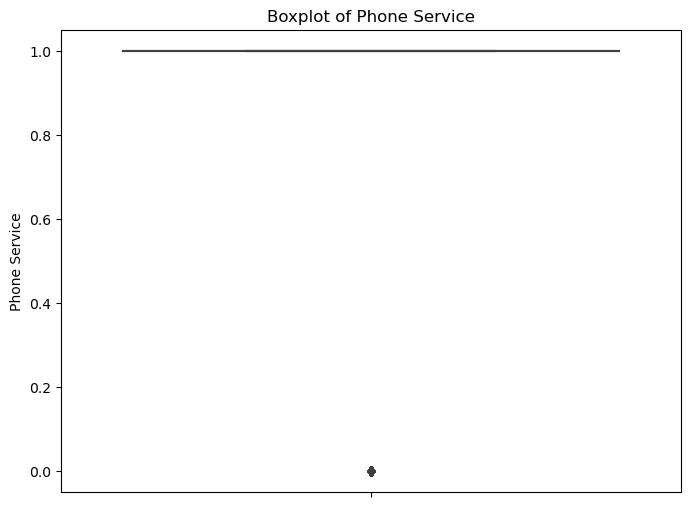

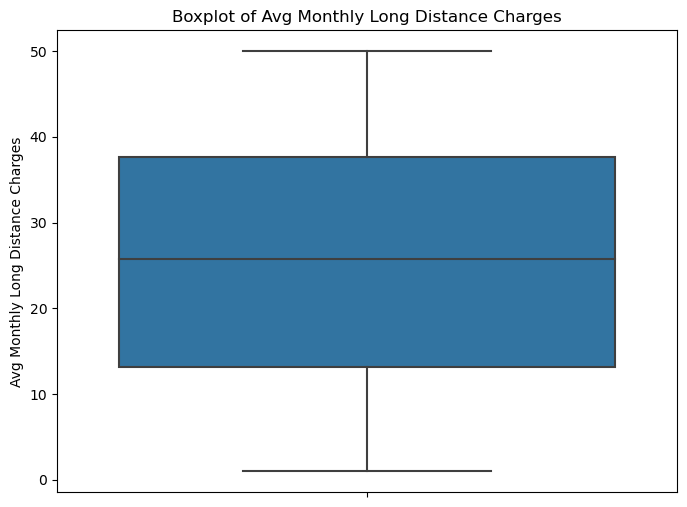

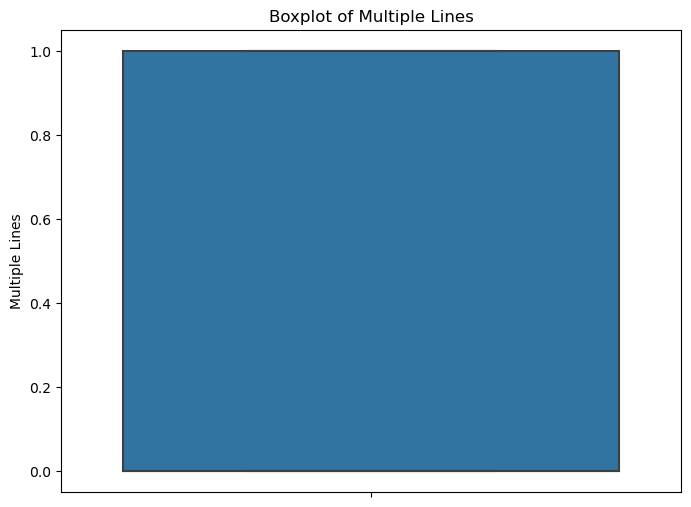

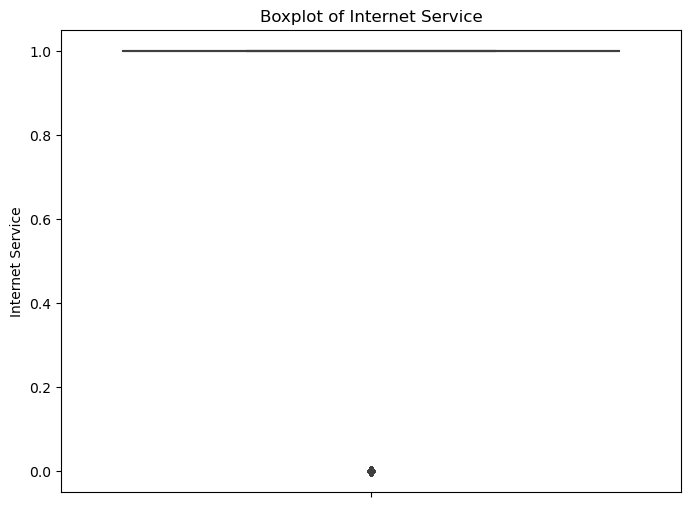

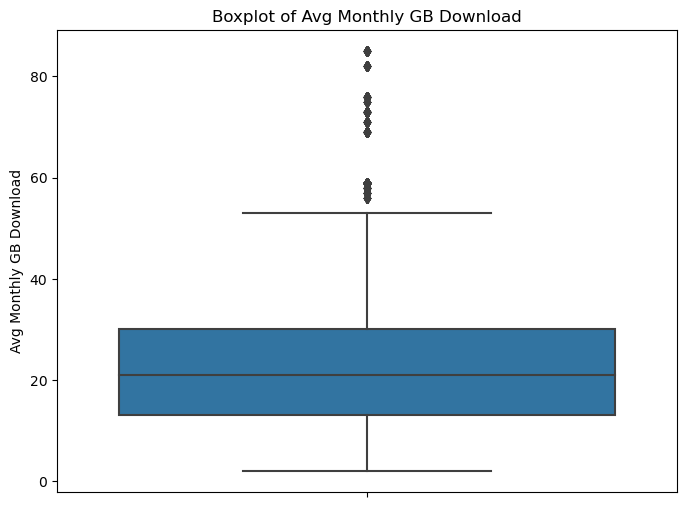

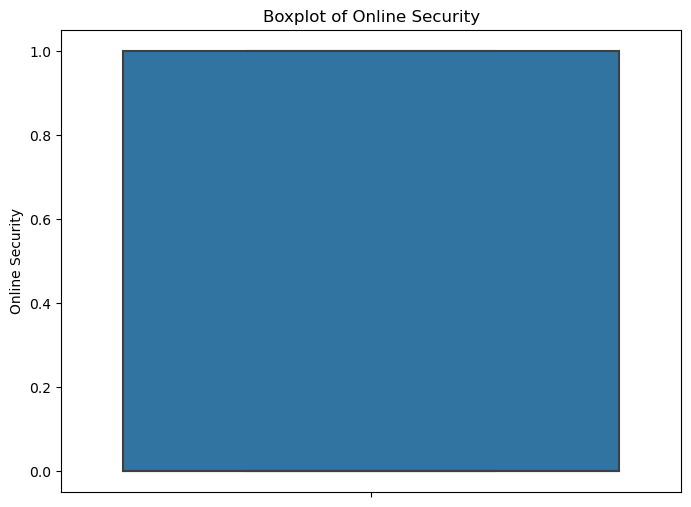

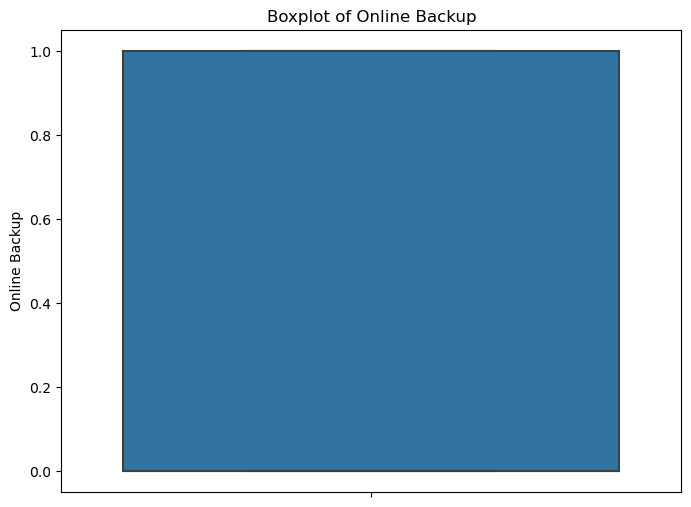

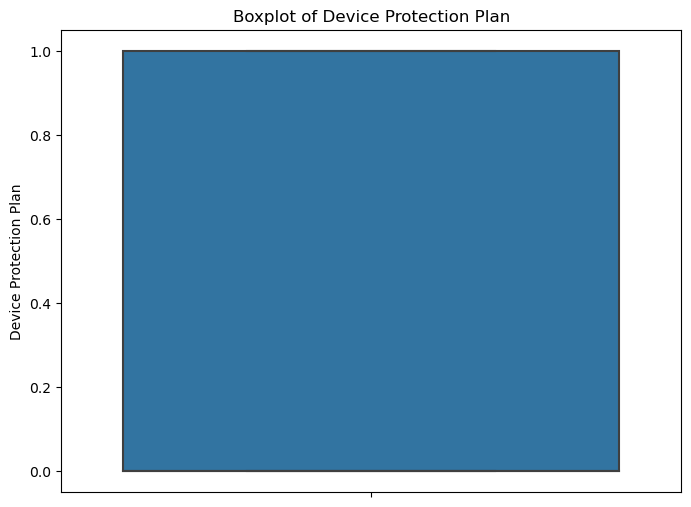

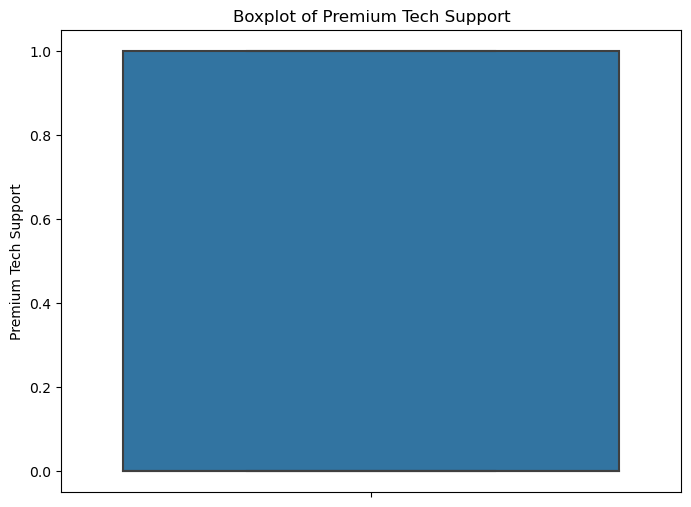

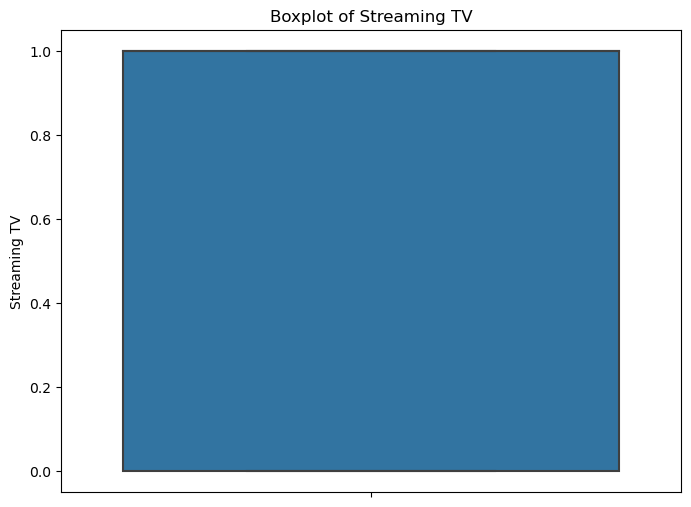

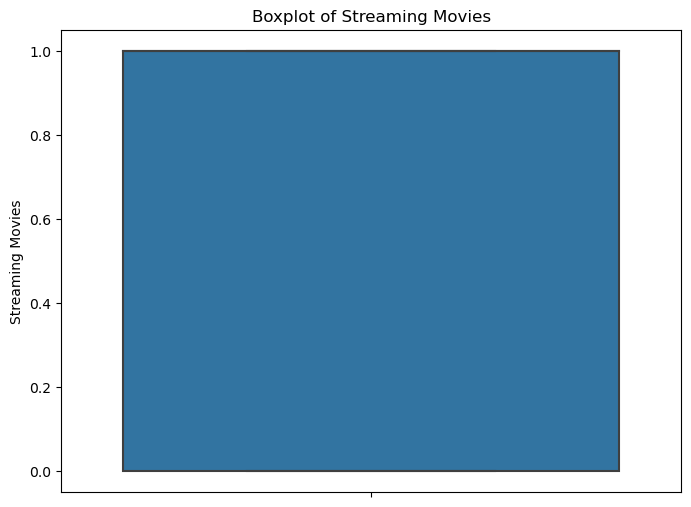

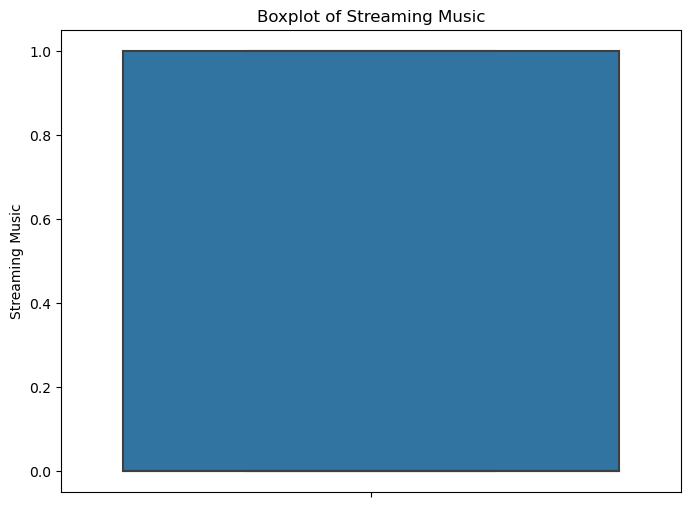

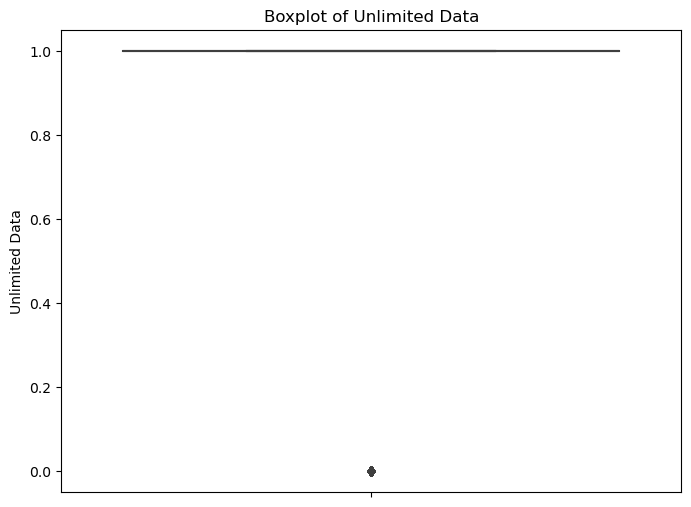

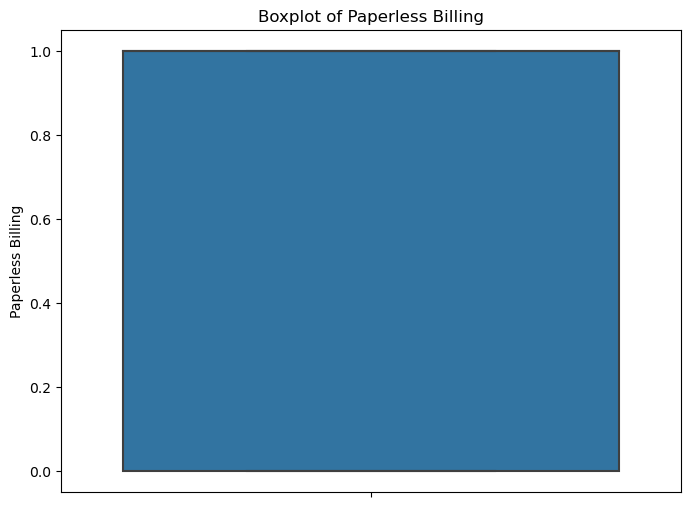

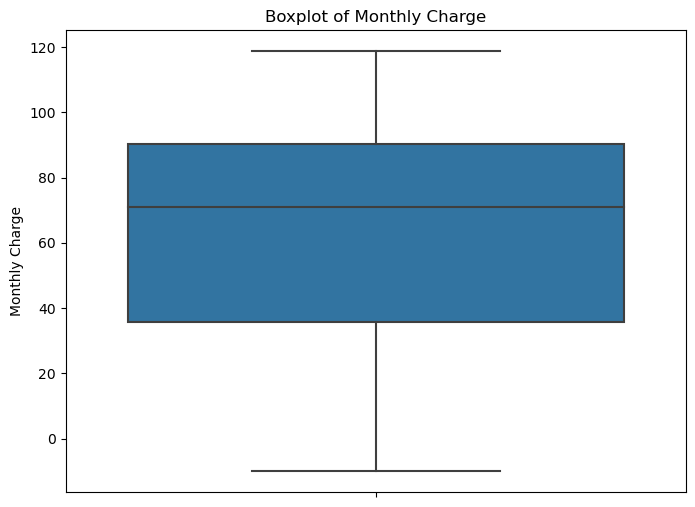

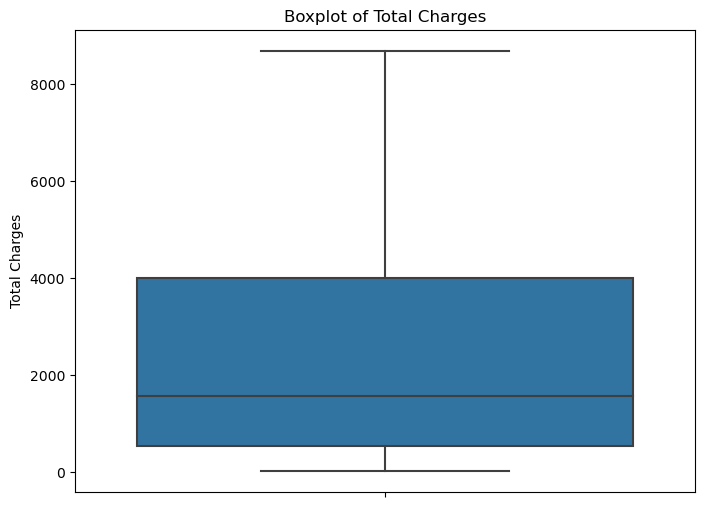

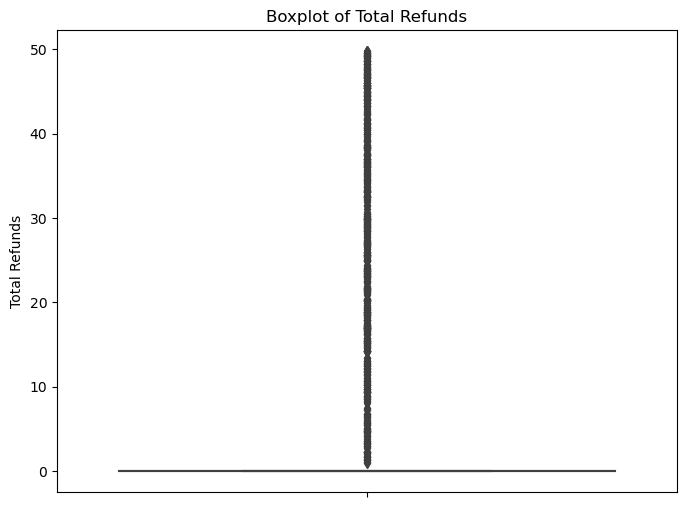

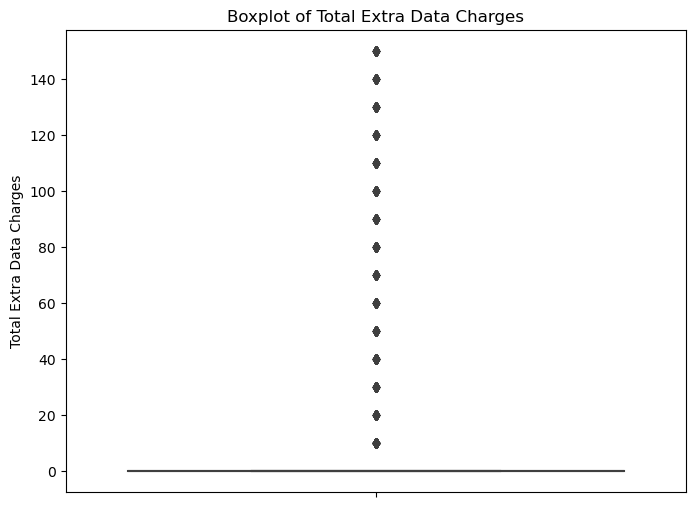

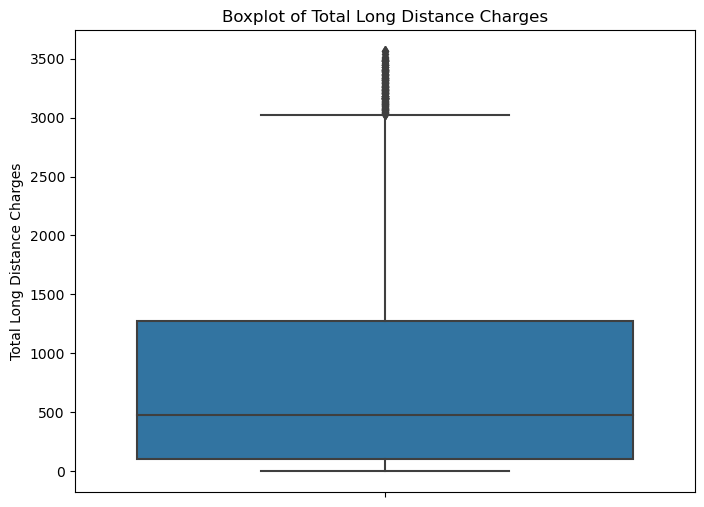

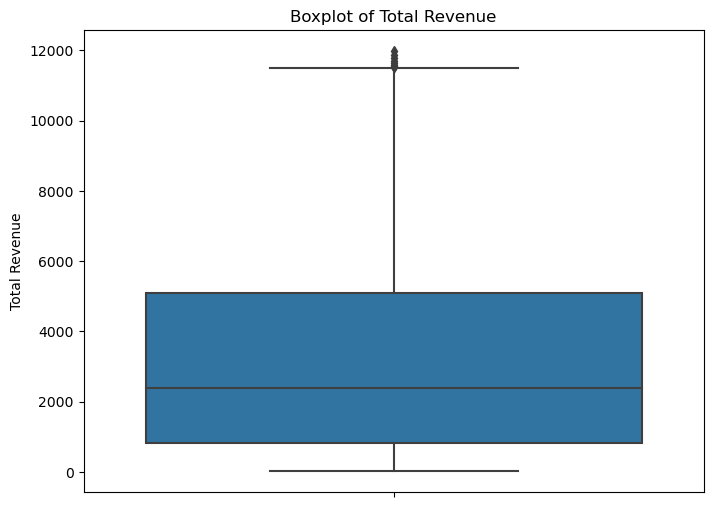

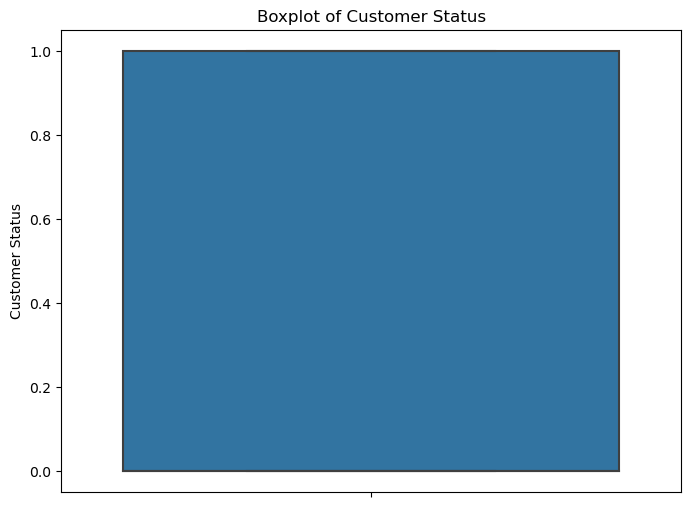

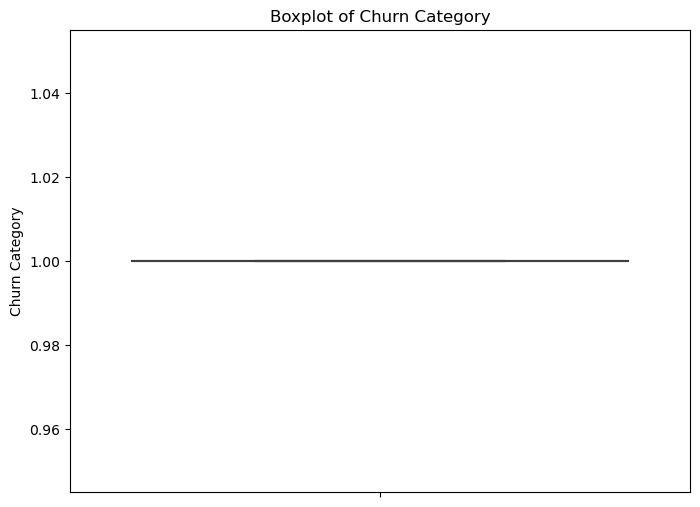

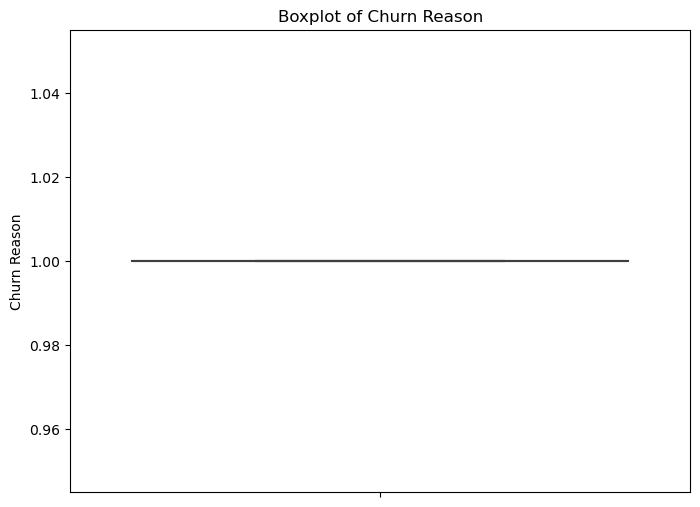

In [19]:
data = customer

# Loop through all the columns in the dataset and plot boxplots for numeric features
for column in data.columns:
    # Check if the column is numeric
    if data[column].dtype in ['int64', 'float64']:  # Only plot numeric columns
        plt.figure(figsize=(8, 6))  # Set the figure size for each plot
        sns.boxplot(y=data[column])  # Plot boxplot for each feature
        plt.title(f'Boxplot of {column}')  # Set plot title
        plt.show()  # Display the plot


## Robust Scaling due to non-normal data

In [20]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Select only numeric columns for scaling
numeric_cols = customer.select_dtypes(include=['int64', 'float64']).columns

# Apply the RobustScaler to the selected numeric columns
customer[numeric_cols] = scaler.fit_transform(customer[numeric_cols])

# Check the scaled data
print(customer.head())
print(customer.shape)

   Customer ID  Gender       Age  Married  Number of Dependents  City  \
0            0    -1.0 -0.333333      0.0                   0.0   346   
1            1     0.0  0.000000     -1.0                   0.0   368   
2            2     0.0  0.148148     -1.0                   0.0   222   
3            3     0.0  1.185185      0.0                   0.0   587   
4            4    -1.0  1.074074      0.0                   0.0   139   

   Zip Code  Latitude  Longitude  Number of Referrals  ...  Customer Status  \
0 -0.093189 -0.339291   0.157641             0.666667  ...              0.0   
1 -0.718266 -0.498414   0.365772             0.000000  ...              0.0   
2 -0.278328 -0.622058   0.439386             0.000000  ...              1.0   
3  0.317957  0.423085  -0.658012             0.333333  ...              1.0   
4 -0.159752 -0.482785   0.136485             1.000000  ...              1.0   

   Churn Category  Churn Reason  Missing  Internet Type_DSL  \
0             NaN      

In [21]:
customer.head(5)

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Customer Status,Churn Category,Churn Reason,Missing,Internet Type_DSL,Internet Type_Fiber Optic,Contract_One Year,Contract_Two Year,Payment Method_Credit Card,Payment Method_Mailed Check
0,0,-1.0,-0.333333,0.0,0.0,346,-0.093189,-0.339291,0.157641,0.666667,...,0.0,NaN,NaN,1,0,0,1,0,1,0
1,1,0.0,0.000000,-1.0,0.0,368,-0.718266,-0.498414,0.365772,0.000000,...,0.0,NaN,NaN,1,0,0,0,0,1,0
2,2,0.0,0.148148,-1.0,0.0,222,-0.278328,-0.622058,0.439386,0.000000,...,1.0,0.0,0.0,0,0,1,0,0,0,0
3,3,0.0,1.185185,0.0,0.0,587,0.317957,0.423085,-0.658012,0.333333,...,1.0,0.0,0.0,0,0,1,0,0,0,0
4,4,-1.0,1.074074,0.0,0.0,139,-0.159752,-0.482785,0.136485,1.000000,...,1.0,0.0,0.0,0,0,1,0,0,1,0


## Iterative Imputation

In [22]:

# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply imputer to the dataset (it works on numeric data by default)
imputed_data = imputer.fit_transform(customer)

# Convert imputed data back to a DataFrame with the original column names
customer = pd.DataFrame(imputed_data, columns=customer.columns)

# Check the imputed data
customer.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Customer Status,Churn Category,Churn Reason,Missing,Internet Type_DSL,Internet Type_Fiber Optic,Contract_One Year,Contract_Two Year,Payment Method_Credit Card,Payment Method_Mailed Check
0,0.0,-1.0,-0.333333,0.0,0.0,346.0,-0.093189,-0.339291,0.157641,0.666667,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.000000,-1.0,0.0,368.0,-0.718266,-0.498414,0.365772,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0.0,0.148148,-1.0,0.0,222.0,-0.278328,-0.622058,0.439386,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,0.0,1.185185,0.0,0.0,587.0,0.317957,0.423085,-0.658012,0.333333,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,-1.0,1.074074,0.0,0.0,139.0,-0.159752,-0.482785,0.136485,1.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Stratified Train-Test Split

In [23]:
customer = customer.drop(['Missing'], axis =1)
# Assuming 'Customer Status' is your target variable and the rest are features
X = customer.drop('Customer Status', axis=1)  # Features
y = customer['Customer Status']  # Target

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check the distribution in the train and test sets to confirm stratification
print("Train set distribution:\n", y_train.value_counts())
print("Test set distribution:\n", y_test.value_counts())


Train set distribution:
 0.0    3776
1.0    1495
Name: Customer Status, dtype: int64
Test set distribution:
 0.0    944
1.0    374
Name: Customer Status, dtype: int64


## Random Forest

In [29]:


# Initialize and train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate performance
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.8657056145675266

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       944
         1.0       0.86      0.63      0.73       374

    accuracy                           0.87      1318
   macro avg       0.86      0.79      0.82      1318
weighted avg       0.86      0.87      0.86      1318



## Logistic Regression

In [30]:

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_logreg = log_reg.predict(X_test)

# Evaluate performance
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))


Logistic Regression Performance:
Accuracy: 0.8368740515933232

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       944
         1.0       0.72      0.70      0.71       374

    accuracy                           0.84      1318
   macro avg       0.80      0.80      0.80      1318
weighted avg       0.84      0.84      0.84      1318



C:\Users\vadre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
